In [50]:
import pandas as pd
import pickle
def save(data , fn):
    with open(fn, 'wb') as f:
        pickle.dump(data, f)
def load(fn): 
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

In [51]:
days = []
prices = []

In [52]:
TRADE3 = load("./TRADE_201903.obj")
for i in TRADE3.keys():     
    days.append(i)
    prices.append(TRADE3[i]["Price"].iloc[-1])

In [53]:
TRADE4 = load("./TRADE_201904.obj")
for i in TRADE4.keys():     
    days.append(i)
    prices.append(TRADE4[i]["Price"].iloc[-1])

In [54]:
TRADE5 = load("./TRADE_201905.obj")
for i in TRADE5.keys():     
    days.append(i)
    prices.append(TRADE5[i]["Price"].iloc[-1])

In [55]:
TRADE6 = load("./TRADE_201906.obj")
for i in TRADE6.keys():     
    days.append(i)
    prices.append(TRADE6[i]["Price"].iloc[-1])

In [56]:
import math
import datetime
from datetime import datetime
import numpy as np
from scipy.stats import norm

class EuropeanCall:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1
    
    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration           
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)   
        
class EuropeanPut:

    def put_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1 - 1
    
    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2
    
    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.put_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [57]:
from datetime import datetime
days_new = []
for i in days:
    time = f'{i[0:4]}-{i[4:6]}-{i[6:]}'
    date_time_obj = datetime.strptime(time, '%Y-%m-%d')
    days_new.append(date_time_obj)    

In [58]:
start_date = days_new[0]
ex = days_new[len(days)-1]
total = ex-start_date # จำนวนวันทั้งหมด ตั้งแต่วันแรกถึงวันคบกำหนด

In [59]:
vol = 0.2285808933847129

In [60]:
# long put option : strike price=130, r=6%
initial_lp = EuropeanPut(prices[0], vol, 130, total.days/365, 0.06)

In [61]:
time = []
for i in range(0,len(days_new)):
    date = days_new[i]
    t = ex-date
    if t.days==0 :
        time.append(1)
        continue
    time.append(t.days)

In [62]:
# hedge delta : delta ของการhedge แต่ละครั้ง
# lp_delta : delta ของ long put option แต่ละรอบ
# opt_price ราคา option ของแต่ละวัน
hedge_deltas = []
lp_deltas = []
opt_price = []
for i in range(0,len(days)):
    put = EuropeanPut(prices[i], initial_lp.asset_volatility, initial_lp.strike_price, time[i]/365, initial_lp.risk_free_rate)
    hedge_deltas.append(-1*put.delta)    
    lp_deltas.append(put.delta)
    opt_price.append(put.price)

In [63]:
contract = 10000 # มี option ทั้งหมด 10,000 สัญญา
share_per_contract = 100 # สัญญาละ 100 หุ้น
total_share = share_per_contract*contract
lp_option_price = initial_lp.price
premium = lp_option_price*total_share # ค่า premium = option price x จำนวนหุ้นทั้งหมด
start_price = prices[0]
share_held = round(total_share*hedge_deltas[0]) # จำนวนหุ้นที่จะlong เพื่อhedgeในวันแรก
share_held = (share_held // 100) * 100
cumulative_cost = round(share_held*prices[0]) # เงินที่ต้องใช้ในการซื้อหุ้นมาถือเพื่อ hedge ในวันแรก
funding_interest = round(share_held*prices[0]*initial_lp.risk_free_rate/365) # funding interest จากการซื้อหุ้นของวันแรก

In [64]:
share_helds = []
funding_interests = []
cumulative_costs = []
share_helds.append(share_held)
funding_interests.append(funding_interest)
cumulative_costs.append(cumulative_cost)
PandLs = []
PandLs.append(round(-premium)) # profit and loss ของวันแรก เท่ากับ -1 * premium

In [65]:
# คำนวณ share held, funding interest, cumulative และ daily return ของแต่ละวัน
for i in range(1,len(days)):    
    share_held = round(total_share*hedge_deltas[i])
    share_held = (share_held // 100) * 100
    d_share_held = share_held-share_helds[i-1] # เช็คว่าปริมาณหุ้นที่ถือเพื่อทำการ hedge ของวันนี้ มากกว่าหรือน้อยกว่าปริมาณหุ้นที่ถือเมื่อวาน
    if d_share_held < 0: # ถ้าผลต่างเป็นลบ แปลว่าเราจะขายหุ้นที่ถือออกไป
        if d_share_held <= -100: # เช็คว่าหุ้นที่จะขายออกไป มีปริมาณมากกว่า100หรือไม่
            cost = prices[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ได้จากการขายหุ้นออกไป จะนำไปหักล้างกับค่า cumulative
        elif d_share_held > -100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการขาย hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas[i] = hedge_deltas[i-1]
        cumulative_cost = cumulative_cost+funding_interests[i-1] # ค่า funding interest ของรอบที่แล้ว จะนำมารวมกับcumulative
    elif d_share_held > 0: # ถ้าผลต่างเป็นบวก แปลว่าเราจะซื้อหุ้นมาถือเพิ่ม
        if d_share_held >= 100: # เช็คว่าหุ้นที่จะซื้อ มีปริมาณมากกว่า100หรือไม่
            cost = prices[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ใช้ซื้อหุ้นมาถือเพิ่ม จะนำไปรวมกับ cumulative
        elif d_share_held < 100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการซื้อhedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas[i] = hedge_deltas[i-1]
        cumulative_cost = cumulative_cost+funding_interests[i-1] # ค่า funding interest ของรอบที่แล้ว จะนำมารวมกับcumulative
    share_held = round(total_share*hedge_deltas[i])
    share_held = (share_held // 100) * 100
    share_helds.append(share_held)
    cumulative_costs.append(round(cumulative_cost))
    funding_interest = round(share_held*prices[i]*initial_lp.risk_free_rate/365)
    funding_interests.append(funding_interest)
    d_opt_price = opt_price[i] - opt_price[i-1] # หาผลต่างของราคา option ของวันนี้กับวันที่ผ่านมา
    PandL = d_opt_price*total_share - cumulative_cost + share_held * prices[i] - premium
# p&l คิดจากผลต่างของราคา option คูณกับจำนวนหุ้นทั้งหมด - cumulative ที่สะสมมาทั้งหมด + ปริมาณหุ้นที่ซื้อมาถือคูณกับราคาของหุ้นอ้างอิง - premium
    PandLs.append(round(PandL))

In [66]:
if prices[len(prices)-1] < initial_lp.strike_price - lp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดน้อยกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ ITM
    print("ITM")
    PandL = (total_share - share_helds[len(share_helds)-1]) * (-1 * prices[len(prices)-1]) + initial_lp.strike_price * total_share - premium - cumulative_costs[len(cumulative_costs)-1]
#p&lคิดจาก ปริมาณหุ้นที่ต้องซื้อเพิ่มเพื่อให้ครบตามสัญญา คูณกับราคาหุ้นอ้างอิงวันสุดท้าย          + ราคาstrike priceคูณกับปริมาณหุ้นตามสัญญา  -premium-cumulative ที่สะสมมาทั้งหมด
elif prices[len(prices)-1] >= initial_lp.strike_price - lp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดมากกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ OTM
    print("OTM")
    PandL = -premium - cumulative_costs[len(cumulative_costs)-1]+share_helds[len(share_helds)-1]*prices[len(prices)-1]
#p&lคิดจาก-1*premium-cumulative ที่สะสมมาทั้งหมด                       บวกกับปริมาณหุ้นที่ซื้อมาถือเพิ่มคูณกับราคาของหุ้นอ้างอิงวันสุดท้าย
PandL1 = round(PandL)
print("profit and loss 1 =", PandL1)

OTM
profit and loss 1 = -761356


In [67]:
PandLs[len(PandLs)-1] = PandL1

In [68]:
import pandas as pd

# นำข้อมูลต่างๆ มาแสดงผลในรูปแบบ DataFrame
df_lp =  pd.DataFrame(
{"asset_price" : prices,
 "option price" : opt_price,
 "long put delta" : lp_deltas,
 "hedge delta" : hedge_deltas,
 "share held" : share_helds,
 "funding interest" : funding_interests,
 "cumulative costs" : cumulative_costs,
 "profit and loss" : PandLs,
}, 
index = days_new)

In [69]:
df_lp

,asset_price,option price,long put delta,hedge delta,share held,funding interest,cumulative costs,profit and loss
2019-03-01,123.5000,8.712102,-0.570585,0.570585,570500,11582,70456750,-8712102
2019-03-04,122.3600,9.340923,-0.601646,0.601646,601600,12101,74273728,-8745233
2019-03-05,122.5000,9.244146,-0.599345,0.599345,599300,12068,74004079,-9398708
2019-03-06,121.5000,9.844072,-0.625048,0.625048,625000,12483,77138697,-9313373
2019-03-07,122.5000,9.218348,-0.601635,0.601635,601600,12114,74284680,-9926506
...,...,...,...,...,...,...,...,...
2019-06-24,136.0000,0.033982,-0.027112,0.027112,27100,606,-4264201,-949974
2019-06-25,135.5000,0.021924,-0.020990,0.020990,20900,466,-5103695,-788514
2019-06-26,134.0000,0.031042,-0.034459,0.034459,34400,758,-3294229,-799155
2019-06-27,135.3895,0.000133,-0.000319,0.000319,300,7,-7910253,-792142


In [70]:
days2 = []
prices2 = []
hours = []
timestamps = []

In [71]:
first = 1
for i in TRADE3.keys():     
    for j in TRADE3[i]['Timestamp'].keys():
        now = TRADE3[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before = now
            continue
        if now == before:
            before = now
            price = TRADE3[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now)
        days2.append(i)
        timestamps.append(TRADE3[i]['Timestamp'][j])
        before = now

In [72]:
first = 1
for i in TRADE4.keys():     
    for j in TRADE4[i]['Timestamp'].keys():
        now4 = TRADE4[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before4 = now4
            continue
        if now4 == before4:
            before4 = now4
            price = TRADE4[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now4)
        days2.append(i)
        timestamps.append(TRADE4[i]['Timestamp'][j])
        before4 = now4

In [73]:
first = 1
for i in TRADE5.keys():     
    for j in TRADE5[i]['Timestamp'].keys():
        now5 = TRADE5[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before5 = now5
            continue
        if now5 == before5:
            before5 = now5
            price = TRADE5[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now5)
        days2.append(i)
        timestamps.append(TRADE5[i]['Timestamp'][j])
        before5 = now5

In [74]:
first = 1
for i in TRADE6.keys():     
    for j in TRADE6[i]['Timestamp'].keys():
        now6 = TRADE6[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before6 = now6
            continue
        if now6 == before6:
            before6 = now6
            price = TRADE6[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now6)
        days2.append(i)
        timestamps.append(TRADE6[i]['Timestamp'][j])
        before6 = now6

In [75]:
t0 = timestamps[0]
tfin = timestamps[len(timestamps)-1]
duration = tfin-t0
duration_in_s = duration.total_seconds() 
total_h = divmod(duration_in_s, 3600)[0] # จำนวนชั่วโมงทั้งหมด ตั้งแต่วันแรกถึงวันครบกำหนด

In [76]:
class EuropeanCall2:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1
    
    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration           
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate) 
        
class EuropeanPut2:

    def put_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1 - 1
    
    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2
    
    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.put_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [77]:
# long put option : strike price=130, r=6%, 8760คือจำนวนชั่วโมงทั้งหมดของ1ปี นำมาใช้แทน365ที่เป็นจำนวนวันทั้งหมด
initial_lp2 = EuropeanPut2(prices2[0], vol, 130, total_h/8760, 0.06)

In [78]:
t = []
for i in range(0,len(days2)):
    now = timestamps[i]
    duration = tfin - now
    duration_in_s = duration.total_seconds() 
    total_h = divmod(duration_in_s, 3600)[0]
    if total_h==0 :
        t.append(1)
        continue
    t.append(total_h)

In [79]:
# hedge delta 2 : delta ของการhedge แต่ละครั้ง
# lp_delta 2 : delta ของ long put option แต่ละรอบ
# opt_price2  ราคา option ของแต่ละชั่วโมง
hedge_deltas2 = []
lp_deltas2 = []
opt_price2 = []
for i in range(0,len(days2)):
    put = EuropeanPut2(prices2[i], initial_lp2.asset_volatility, initial_lp2.strike_price, t[i]/8760, initial_lp2.risk_free_rate)
    hedge_deltas2.append(-1*put.delta)
    lp_deltas2.append(put.delta)
    opt_price2.append(put.price)

In [80]:
lp_option_price = initial_lp2.price
premium = lp_option_price*total_share # ค่า premium = option price x จำนวนหุ้นทั้งหมด
start_price = prices2[0]
share_held = round(total_share*hedge_deltas2[0]) # จำนวนหุ้นที่จะlong เพื่อhedgeในวันแรก
share_held = (share_held // 100) * 100
cumulative_cost = round(share_held*prices2[0]) # เงินที่ต้องใช้ในการซื้อหุ้นมาถือเพื่อ hedge ในวันแรก
funding_interest = round(cumulative_cost*initial_lp2.risk_free_rate/8760) # funding interest จากการซื้อหุ้นของวันแรก

In [81]:
share_helds2 = []
funding_interests2 = []
cumulative_costs2 = []
share_helds2.append(share_held)
funding_interests2.append(funding_interest)
cumulative_costs2.append(cumulative_cost)
PandLs2 = []
PandLs2.append(round(-premium)) # profit and loss ของชั่วโมงแรก เท่ากับ -1 * premium

In [82]:
# คำนวณ share held, funding interest, cumulative และ daily return ของแต่ละชั่วโมง
for i in range(1,len(timestamps)):  
    share_held = round(total_share*hedge_deltas2[i])
    share_held = (share_held // 100) * 100
    d_share_held = share_held-share_helds2[i-1] # เช็คว่าปริมาณหุ้นที่ถือเพื่อทำการ hedge ของชั่วโมงปัจจุบัน มากกว่าหรือน้อยกว่าปริมาณหุ้นที่ถือเมื่อชั่วโมงที่แล้ว
    if d_share_held < 0: # ถ้าผลต่างเป็นลบ แปลว่าเราจะขายหุ้นที่ถือออกไป
        if d_share_held <= -100: # เช็คว่าหุ้นที่จะขายออกไป มีปริมาณมากกว่า100หรือไม่
            cost = prices2[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ได้จากการขายหุ้นออกไป จะนำไปหักล้างกับค่า cumulative
        elif d_share_held > -100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการขาย hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas2[i] = hedge_deltas2[i-1]
        cumulative_cost = cumulative_cost+funding_interests2[i-1] # ค่า funding interest ของรอบที่แล้ว จะนำมารวมกับcumulative
    elif d_share_held > 0: # ถ้าผลต่างเป็นบวก แปลว่าเราจะซื้อหุ้นมาถือเพิ่ม
        if d_share_held > 100: # เช็คว่าหุ้นที่จะซื้อ มีปริมาณมากกว่า100หรือไม่
            cost = prices2[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ใช้ซื้อหุ้นมาถือเพิ่ม จะนำไปรวมกับ cumulative
        elif d_share_held < 100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการซื้อhedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas2[i] = hedge_deltas2[i-1]
        cumulative_cost = cumulative_cost+funding_interests2[i-1] # ค่า funding interest ของรอบที่แล้ว จะนำมารวมกับcumulative
    share_held = round(total_share*hedge_deltas2[i])
    share_held = (share_held // 100) * 100
    share_helds2.append(share_held)
    cumulative_costs2.append(round(cumulative_cost))
    funding_interest = round(share_held*prices2[i]*initial_lp2.risk_free_rate/8760)
    funding_interests2.append(funding_interest)
    d_opt_price = opt_price2[i] - opt_price2[i-1] # หาผลต่างของราคา option ของชั่วโมงปัจจุบันกับชั่วโมงที่ผ่านมา
    PandL = d_opt_price*total_share - cumulative_cost + share_held * prices2[i] - premium
# p&l คิดจากผลต่างของราคา option คูณกับจำนวนหุ้นทั้งหมด - cumulative ที่สะสมมาทั้งหมด + ปริมาณหุ้นที่ซื้อมาถือคูณกับราคาของหุ้นอ้างอิง - premium
    PandLs2.append(round(PandL))

In [83]:
if prices2[len(prices2)-1] < initial_lp2.strike_price - lp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดน้อยกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ ITM
    print("ITM")
    PandL = (total_share - share_helds2[len(share_helds2)-1]) * (-1 * prices2[len(prices2)-1]) + initial_lp2.strike_price * total_share - premium - cumulative_costs2[len(cumulative_costs2)-1]
#p&lคิดจาก ปริมาณหุ้นที่ต้องซื้อเพิ่มเพื่อให้ครบตามสัญญา คูณกับราคาหุ้นอ้างอิงวันสุดท้าย          + ราคาstrike priceคูณกับปริมาณหุ้นตามสัญญา  -premium-cumulative ที่สะสมมาทั้งหมด
elif prices2[len(prices2)-1] >= initial_lp2.strike_price - lp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดมากกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ OTM
    print("OTM")
    PandL = -premium - cumulative_costs2[len(cumulative_costs2)-1]+share_helds2[len(share_helds2)-1]*prices2[len(prices2)-1]
#p&lคิดจาก-1*premium-cumulative ที่สะสมมาทั้งหมด                       บวกกับปริมาณหุ้นที่ซื้อมาถือเพิ่มคูณกับราคาของหุ้นอ้างอิงวันสุดท้าย
PandL2 = round(PandL)
print("profit and loss 2 =", PandL2)

OTM
profit and loss 2 = 2469072


In [84]:
PandLs2[len(PandLs2)-1] = PandL2

In [85]:
# นำข้อมูลต่างๆ มาแสดงผลในรูปแบบ DataFrame
df_lp2 =  pd.DataFrame(
{"asset_price" : prices2,
 "option price" : opt_price2,
 "long put delta" : lp_deltas2,
 "hedge delta" : hedge_deltas2,
 "share held:" : share_helds2,
 "funding interest" : funding_interests2,
 "cumulative costs" : cumulative_costs2,
 "profit and loss" : PandLs2,
}, 
index = timestamps)

In [86]:
df_lp2

,asset_price,option price,long put delta,hedge delta,share held:,funding interest,cumulative costs,profit and loss
2019-03-01 10:00:41.107,125.0,7.886770e+00,-5.338356e-01,5.338356e-01,533800,457,66725000,-7886770
2019-03-01 11:00:11.263,124.5,8.156732e+00,-5.460141e-01,5.460141e-01,546000,466,68244357,-7884165
2019-03-01 12:01:21.835,124.5,8.155522e+00,-5.460898e-01,5.460898e-01,546000,466,68244357,-8155337
2019-03-01 14:27:27.359,124.5,8.154311e+00,-5.461655e-01,5.461655e-01,546100,466,68244823,-8143354
2019-03-01 15:00:21.196,124.5,8.153706e+00,-5.462034e-01,5.462034e-01,546200,466,68245289,-8130765
...,...,...,...,...,...,...,...,...
2019-06-28 11:00:03.658,136.0,5.790701e-18,-1.110223e-16,1.110223e-16,0,0,-10355842,2469072
2019-06-28 12:00:01.158,135.5,7.747300e-19,0.000000e+00,-0.000000e+00,0,0,-10355842,2469072
2019-06-28 14:25:10.336,135.5,1.305451e-66,0.000000e+00,-0.000000e+00,0,0,-10355842,2469072
2019-06-28 15:00:05.962,135.5,1.305451e-66,0.000000e+00,-0.000000e+00,0,0,-10355842,2469072


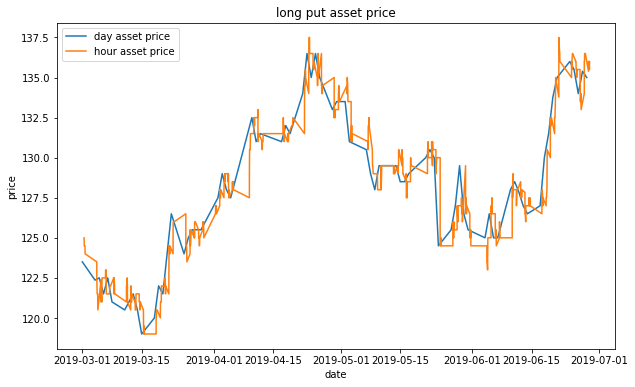

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["asset_price"], label="day asset price")
plt.plot(df_lp2.index.tolist(), df_lp2["asset_price"], label="hour asset price")

plt.title('long put asset price')
plt.xlabel("date")
plt.ylabel("price")

plt.legend()

plt.show()

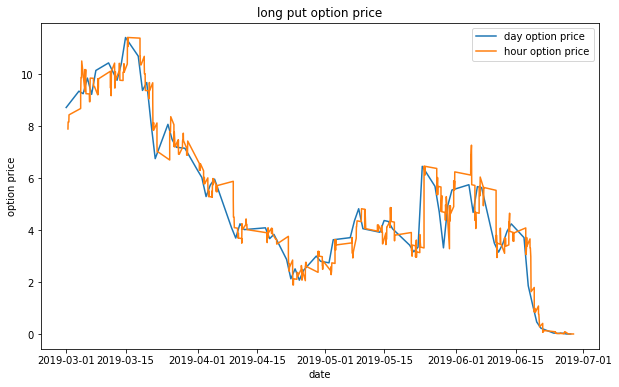

In [90]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["option price"], label="day option price")
plt.plot(df_lp2.index.tolist(), df_lp2["option price"], label="hour option price")

plt.title('long put option price')
plt.xlabel("date")
plt.ylabel("option price")

plt.legend()

plt.show()

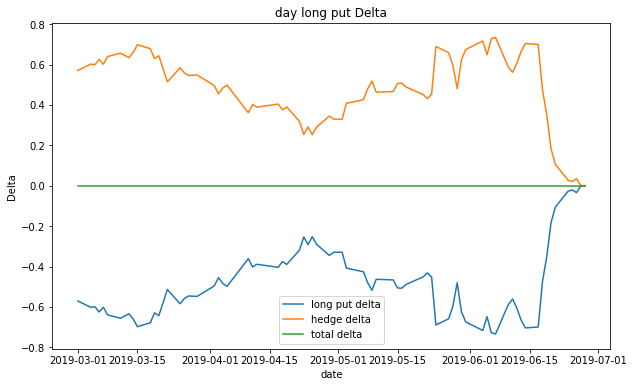

In [91]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["long put delta"], label="long put delta")
plt.plot(df_lp.index.tolist(), df_lp["hedge delta"], label="hedge delta")
plt.plot(df_lp.index.tolist(), df_lp["long put delta"]+df_lp["hedge delta"], label="total delta")

plt.title('day long put Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

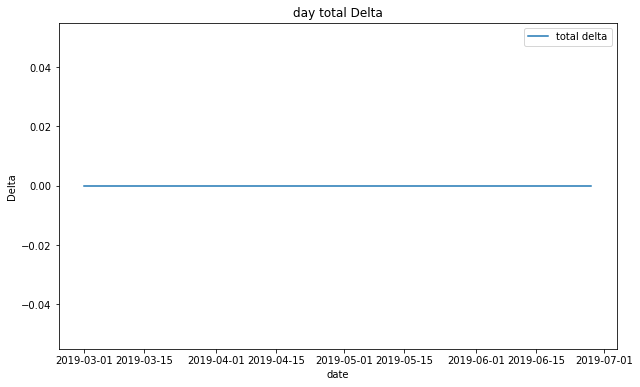

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["long put delta"]+df_lp["hedge delta"], label="total delta")

plt.title('day total Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

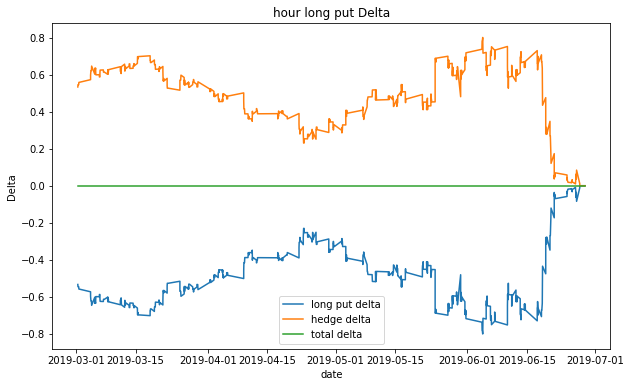

In [93]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp2.index.tolist(), df_lp2["long put delta"], label="long put delta")
plt.plot(df_lp2.index.tolist(), df_lp2["hedge delta"], label="hedge delta")
plt.plot(df_lp2.index.tolist(), df_lp2["long put delta"]+df_lp2["hedge delta"], label="total delta")

plt.title('hour long put Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

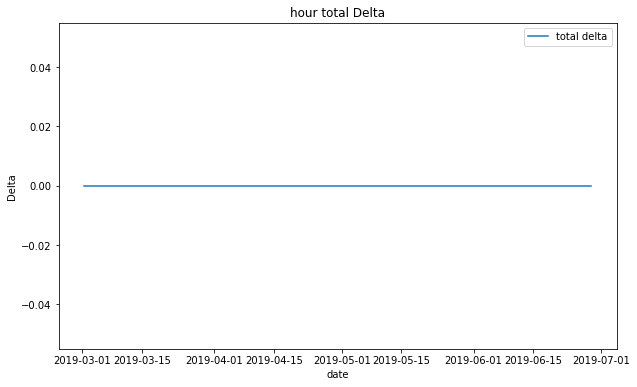

In [94]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp2.index.tolist(), df_lp2["long put delta"]+df_lp2["hedge delta"], label="total delta")

plt.title('hour total Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

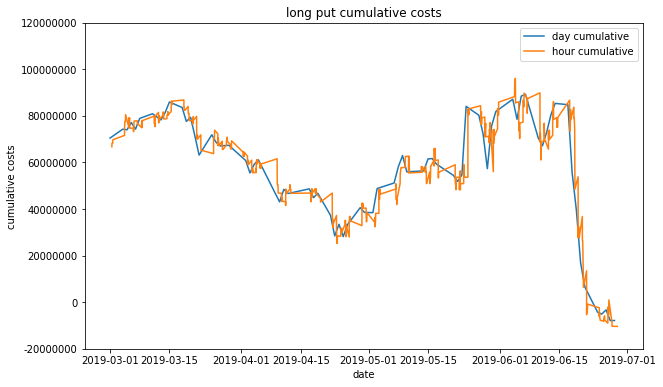

In [95]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["cumulative costs"], label="day cumulative")
plt.plot(df_lp2.index.tolist(), df_lp2["cumulative costs"], label="hour cumulative")

plt.title('long put cumulative costs')
plt.xlabel("date")
plt.ylabel("cumulative costs")

plt.legend()

yy, locs = plt.yticks()
ll = ['%.0f' % a for a in yy]
plt.yticks(yy, ll)

plt.show()

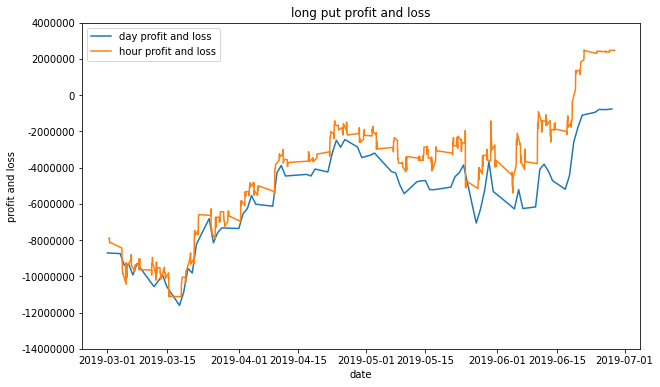

In [96]:
plt.figure(figsize=(10, 6))

plt.plot(df_lp.index.tolist(), df_lp["profit and loss"], label="day profit and loss")
plt.plot(df_lp2.index.tolist(), df_lp2["profit and loss"], label="hour profit and loss")

plt.title('long put profit and loss')
plt.xlabel("date")
plt.ylabel("profit and loss")

plt.legend()

yy, locs = plt.yticks()
ll = ['%.0f' % a for a in yy]
plt.yticks(yy, ll)

plt.show()